## Fine-tuning BERT pre-trained model

Read csv into pandas dataframe

In [7]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd

df = pd.read_csv('imdb-reviews.csv', sep='\t')
# df= df.head(10000)

Create functions used for data cleaning and apply them to our dataframe.

The function data_preprocessing() can be used for any dataframe we want to preprocess/transform later.

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import os

# wordnet unzip some times needs to be done manually
if not os.path.exists('/usr/share/nltk_data/corpora/wordnet'):
    !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

from nltk.corpus import stopwords

def rate_to_pos_neg(row):
  if row['rating'] <= 4:
    return 0
  elif row['rating'] >= 7:
    return 1

def data_preprocessing(df):

  stop = set(stopwords.words('english'))

  df['reviews_edited'] = df['review'].str.lower() # lowercase

  # lemmatize text to group together the different inflected forms of a word so they can be analyzed as a single item
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = nltk.stem.WordNetLemmatizer()

  def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

  df['reviews_edited'] = df['reviews_edited'].apply(lemmatize_text)

  df['reviews_edited'] = df['reviews_edited'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # remove stopwords
  df['reviews_edited'] = df['reviews_edited'].str.replace("n\'t", " not", regex=True) # replace n't with not
  df['reviews_edited'] = df['reviews_edited'].str.replace(r'<br />', ' ', regex=True) # remove html break lines
  df["reviews_edited"] = df['reviews_edited'].str.replace('[^\w\s]','', regex=True) # remove punctuation

  df['target'] = df.apply(rate_to_pos_neg, axis=1)

  return df

df = data_preprocessing(df)

df

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,url,rating,review,reviews_edited,target
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...,thought wa quiet good movie wa fun watch it li...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...,wagon master unique film amongst john fords wo...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...,film ha near perfect film john ford made film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...,gave 4 star ha lot interesting theme many alre...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...,movie really genuine random really hard find m...,1
...,...,...,...,...,...
45003,http://www.imdb.com/title/tt0449000/usercomments,1.0,I don't even know where to begin...<br /><br /...,even know begin its worth typing review quote...,0
45004,http://www.imdb.com/title/tt0109382/usercomments,1.0,One of the worst movies I saw in the 90s. I'd ...,one worst movie saw 90s id often use benchmark...,0
45005,http://www.imdb.com/title/tt0375560/usercomments,1.0,Baldwin has really stooped low to make such mo...,baldwin ha really stooped low make movies scri...,0
45006,http://www.imdb.com/title/tt0165107/usercomments,1.0,If you liked watching Mel Gibson in Million Do...,liked watching mel gibson million dollar hotel...,0


Create x, y datasets based on the features we need.

In [9]:
df = df[['reviews_edited', 'target']]
x = df[['reviews_edited']]
y = df[['target']]
df

,reviews_edited,target
0,thought wa quiet good movie wa fun watch it li...,1
1,wagon master unique film amongst john fords wo...,1
2,film ha near perfect film john ford made film ...,1
3,gave 4 star ha lot interesting theme many alre...,0
4,movie really genuine random really hard find m...,1
...,...,...
45003,even know begin its worth typing review quote...,0
45004,one worst movie saw 90s id often use benchmark...,0
45005,baldwin ha really stooped low make movies scri...,0
45006,liked watching mel gibson million dollar hotel...,0


Split into train, valitation and test datasets with 80%, 16% and 4% proportion of the whole dataset respectively.

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_val_test, y_train, y_val_test = train_test_split(x, np.ravel(y), test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, np.ravel(y_val_test), test_size=0.2, random_state=42)

Import bert tokenizer.

In [11]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We transform the reviews according to the tokenizer bert provides.

In [12]:
train_encodings = tokenizer(x_train['reviews_edited'].astype(str).values.tolist(), truncation=True, padding=True, return_attention_mask=True, max_length=256, return_tensors='pt')
val_encodings = tokenizer(x_val['reviews_edited'].astype(str).values.tolist(), truncation=True, padding=True, return_attention_mask=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(x_test['reviews_edited'].astype(str).values.tolist(), truncation=True, padding=True, return_attention_mask=True, max_length=256, return_tensors='pt')

We create a custom Dataset class which inherits the Dataset class of torch.utils.data and creates a dataset using the encodings created by the tokenizer and the target datasets created above.

In [13]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchtext

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class CustomDataset(Dataset):

  def __init__(self, x_dataset, y_dataset):

    self.encodings = x_dataset
    self.labels = y_dataset

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def len(self):
    return len(self.labels)

  def __len__(self):
    return len(self.labels)

Create train, validation and test datasets using the class we previously defined and the train, validation and test data we previously splitted. Also print the size of each dataset.

In [14]:
train_dataset = CustomDataset(train_encodings, y_train)
validation_dataset = CustomDataset(val_encodings, y_val)
test_dataset = CustomDataset(test_encodings, y_test)

print("Train size is: ", train_dataset.len())
print("Validation size is: ", validation_dataset.len())
print("Test size is: ", test_dataset.len())

Train size is:  36006
Validation size is:  7201
Test size is:  1801


Batch size needs to be big enough so that we avoid noise, but small enough to allow the model to be trained fast, while using less memory. After experimenting with multiple batch sizes (8, 16, 32, 64) we define it as 16 here.

Bert authors recommend a small number of epochs for fine-tuning, around 4.

In [15]:
batch_size = 16
num_epochs = 4
num_classes = 2

Create dataloaders for each set of data to use for the training, validation and evaluation of the models, later.

In [16]:
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size,
                                               shuffle = True)

In [17]:
validation_dataloader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = batch_size,
                                                    shuffle = True)

In [18]:
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size,
                                              shuffle = True)

We define a model class wrapping `bert-base-uncased` pretrained model which also adds a dropout layer, a linear layer and a softmax before returning the results.

In [19]:
import torch.nn as nn
import transformers
from transformers import BertForSequenceClassification, AdamW

class BERTClassification(nn.Module):
    def __init__ (self):
        super(BERTClassification, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        self.bert_drop = nn.Dropout(0.4)
        self.out = nn.Linear(768, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, ids, mask, token_type_ids, labels=None):
        out, pooledOut = self.bert(ids, attention_mask = mask, token_type_ids=token_type_ids, return_dict=False)

        output = self.bert_drop(pooledOut)

        output = self.softmax(output)
        return self.out(output)

The following function helps us train each of the previous defined models, export statistics about their scores and plot them.

In [20]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, plots = False):
  train_loss = []
  val_loss = []
  train_accuracy = []
  val_accuracy = []
  train_precision = []
  val_precision = []
  train_recall = []
  val_recall = []
  train_f1 = []
  val_f1 = []
  for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
    
      outputs = model(input_ids, attention_mask, token_type_ids)
          
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # no gradients needed
    model.eval()
    with torch.no_grad():

      # checking fit for the training set itself

      all_train_labels = np.array([])
      all_train_predictions = np.array([])
      losses = np.array([])
      for batch in train_dataloader:
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        losses = np.append(losses, loss.item())
        
        all_train_labels = np.append(all_train_labels, labels.cpu().numpy())
        
        all_train_predictions = np.append(all_train_predictions, predictions.cpu().numpy())

      train_loss.append(np.mean(losses))
      train_accuracy.append(accuracy_score(all_train_labels, all_train_predictions))
      train_precision.append(precision_score(all_train_labels, all_train_predictions))
      train_recall.append(recall_score(all_train_labels, all_train_predictions))
      train_f1.append(f1_score(all_train_labels, all_train_predictions))

      # checking fit for validation set

      all_val_labels = np.array([])
      all_val_predictions = np.array([])
      all_val_outputs = np.array([])
      losses = np.array([])

      for batch in validation_dataloader:
            
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        _, predictions = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        losses = np.append(losses, loss.item())
            
        all_val_labels = np.append(all_val_labels, labels.cpu().numpy())
        all_val_predictions = np.append(all_val_predictions, predictions.cpu().numpy())

        if not np.any(all_val_outputs):
          all_val_outputs = outputs.cpu().numpy()
        else:
          all_val_outputs = np.concatenate((all_val_outputs, outputs.cpu().numpy()), axis=0)

      val_loss.append(np.mean(losses))
      val_accuracy.append(accuracy_score(all_val_labels, all_val_predictions))
      val_precision.append(precision_score(all_val_labels, all_val_predictions))
      val_recall.append(recall_score(all_val_labels, all_val_predictions))
      val_f1.append(f1_score(all_val_labels, all_val_predictions))

  # plots / learning curves
  # plots may be False if we are just tuning our model and don't need these curves
  if plots:
    fig, axs = plt.subplots(2, 3, figsize=(15, 7))
    fig.patch.set_facecolor('white')

    axs[0, 0].plot(range(num_epochs), train_loss, label="train set")
    axs[0, 0].plot(range(num_epochs), val_loss, label="validation set")
    axs[0, 0].set_title('Cross Entropy Loss')
    axs[0, 0].set_ylim([0.1, 0.8])
    
    axs[0, 1].plot(range(num_epochs), train_accuracy, label="train set")
    axs[0, 1].plot(range(num_epochs), val_accuracy, label="validation set")
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_ylim([0.65, 1])

    axs[0, 2].plot(range(num_epochs), train_precision, label="train set")
    axs[0, 2].plot(range(num_epochs), val_precision, label="validation set")
    axs[0, 2].set_title('Precision')
    axs[0, 2].set_ylim([0.65, 1])

    axs[1, 0].plot(range(num_epochs), train_recall, label="train set")
    axs[1, 0].plot(range(num_epochs), val_recall, label="validation set")
    axs[1, 0].set_title('Recall')
    axs[1, 0].set_ylim([0.65, 1])

    axs[1, 1].plot(range(num_epochs), train_f1, label="train set")
    axs[1, 1].plot(range(num_epochs), val_f1, label="validation set")
    axs[1, 1].set_title('F1')
    axs[1, 1].set_ylim([0.65, 1])

    # roc curve
    probabilities = F.softmax(torch.from_numpy(all_val_outputs), dim=1)[:, 1]
    y_score = probabilities.detach().cpu().numpy()
    # print(y_val.shape, y_score.shape)
    nn_fpr, nn_tpr, nn_thresholds = roc_curve(all_val_labels, y_score)
    roc_auc = auc(nn_fpr, nn_tpr)

    axs[1, 2].plot(nn_fpr,nn_tpr, label="validation set")
    axs[1, 2].set_title('ROC Curve')
    axs[1, 2].set_ylim([0, 1])
    axs[1, 2].set_xlim([0, 1])
    axs[1, 2].set_ylabel('True Positive Rate')
    axs[1, 2].set_xlabel('False Positive Rate' )
    axs[1, 2].text(0.8, 0.2, 'AUC: '+str(round(roc_auc, 2)), horizontalalignment='center',
                   verticalalignment='center', transform=axs[1, 2].transAxes)

    axs[0][0].legend()
    axs[0][1].legend()
    axs[0][2].legend()
    axs[1][0].legend()
    axs[1][1].legend()
    axs[1][2].legend()

  return all_train_labels, all_train_predictions, all_val_labels, all_val_predictions

Fine tune bert model and get a classification report for both training and validation sets. Then, by examining whether the scores for these sets are close to each other or not, we can determine if the model overfits or underfits. This can also be seen in the plots following these statistics, where the training and validation curves remain very close to each other with a very small generalization gap, showing that no overfitting or underfitting occurs in our model.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train set:
               precision    recall  f1-score   support

         0.0       0.86      0.91      0.89     17950
         1.0       0.91      0.86      0.88     18056

    accuracy                           0.89     36006
   macro avg       0.89      0.89      0.89     36006
weighted avg       0.89      0.89      0.89     36006

Validation set:
               precision    recall  f1-score   support

         0.0       0.86      0.91      0.88      3628
         1.0       0.90      0.85      0.88      3573

    accuracy                           0.88      7201
   macro avg       0.88      0.88      0.88      7201
weighted avg       0.88      0.88      0.88      7201



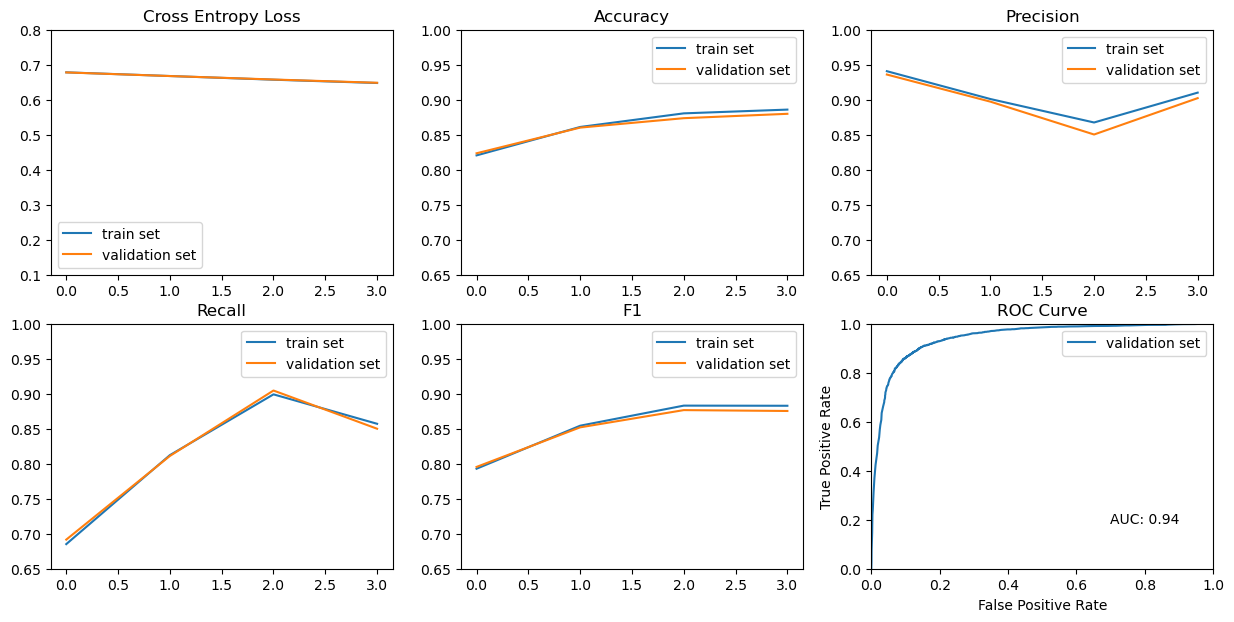

In [21]:
from sklearn.metrics import classification_report
from torch import nn

model = BERTClassification().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00001)

y_train, train_outputs, y_val, val_outputs = train_model(model, num_epochs, train_dataloader,
                                    validation_dataloader, criterion, optimizer, plots = True)

print("Train set:\n", classification_report(y_train, train_outputs))
print("Validation set:\n", classification_report(y_val, val_outputs))

Also save this trained model for later use.

In [22]:
torch.save(model.state_dict(), "model_movies")
model = BERTClassification().to(device)
model.load_state_dict(torch.load("model_movies"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Evaluation of our model using the test set created in the beginning of this notebook. This test set has not been used anywhere so far, so it contains representative random samples that the model has never seen before.

In [23]:
all_test_labels = np.array([])
all_test_predictions = np.array([])

model.eval()

with torch.no_grad():
  for batch in test_dataloader:
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
        
    outputs = model(input_ids, attention_mask, token_type_ids)
        
    _, predictions = torch.max(outputs, 1)
    
    all_test_labels = np.append(all_test_labels, labels.cpu().numpy())

    all_test_predictions = np.append(all_test_predictions, predictions.cpu().numpy())

print("Test set:\n", classification_report(all_test_labels, all_test_predictions))

Test set:
               precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       922
         1.0       0.91      0.86      0.89       879

    accuracy                           0.89      1801
   macro avg       0.89      0.89      0.89      1801
weighted avg       0.89      0.89      0.89      1801



Section for testing with a new test dataset given by the user. Just insert the path of your test csv file in the `path_to_your_test_set` variable and run the code (while having already run the code written before this message).
After running the following code, a classification report providing precision, recall and F-measure for your test set will be printed on the screen.

In [ ]:
#########################################
############# YOUR TEST SET #############
#########################################

path_to_your_test_set = ''

my_df_test = pd.read_csv(path_to_your_test_set, sep='\t')

my_df_test = data_preprocessing(my_df_test)

my_df_test = my_df_test[['reviews_edited', 'target']]
my_x = my_df_test[['reviews_edited']]
my_y = np.ravel(my_df_test[['target']])

my_test_encodings = tokenizer(my_df_test['reviews_edited'].astype(str).values.tolist(), truncation=True, padding=True, return_attention_mask=True, max_length=256, return_tensors='pt')

my_test_dataset = CustomDataset(my_test_encodings, my_y)

my_test_dataloader = torch.utils.data.DataLoader(dataset = my_test_dataset, batch_size = batch_size,
                                              shuffle = True)

all_my_test_labels = np.array([])
all_my_test_predictions = np.array([])

model.eval()

with torch.no_grad():
  for batch in my_test_dataloader:
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
        
    outputs = model(input_ids, attention_mask, token_type_ids)
        
    _, predictions = torch.max(outputs, 1)
    
    all_my_test_labels = np.append(all_my_test_labels, labels.cpu().numpy())

    all_my_test_predictions = np.append(all_my_test_predictions, predictions.cpu().numpy())

print("My test set:\n", classification_report(all_my_test_labels, all_my_test_predictions))